In [68]:
# Create and embedding for searching through past for similar condition finding
import os,sys,inspect
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
from sklearn.preprocessing import MinMaxScaler
from kats.consts import TimeSeriesData
from kats.tsfeatures.tsfeatures import TsFeatures
import itertools
from decimal import Decimal
from IPython.display import clear_output
import faiss  

import warnings
warnings.simplefilter(action='ignore')

In [2]:
path= '../datasets/dow50.csv'
dow = pd.read_csv(path)

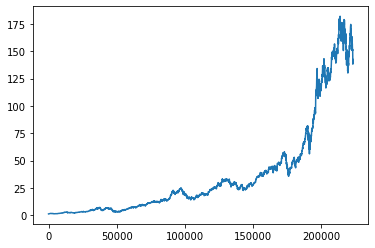

In [3]:
dow[dow.ticker == "AAPL"].Close.plot()

In [4]:

# Define sliding window and step size
SLIDING_WINDOW_SIZE = 64
STEP = 10

In [5]:
def windows(data, window_size, step):
    r = np.arange(len(data))
    s = r[::step]
    z = list(zip(s, s + window_size))
    f = '{0[0]}:{0[1]}'.format
    g = lambda t: data.iloc[t[0]:t[1]]
    return pd.concat(map(g, z), keys=map(f, z))

In [6]:
def get_feature_embedding_for_window(df, stock):
    ts_name = f"{stock.strip('.csv')}_{str(df.Date.min())}_{str(df.Date.max())}"
    scaler=MinMaxScaler()
    df[['Open', 'Close']] = scaler.fit_transform(df[['Open', 'Close']])
    prices = df[['Open', 'Close']].values.tolist()
    flat_values = [item for sublist in prices for item in sublist]
    df = df.rename(columns={"Date":"time"}) 
    ts_df = pd.DataFrame({'time':df.time.repeat(2), 
                          'price':flat_values})
    ts_df.drop_duplicates(keep='first', inplace=True)  

    # Use Kats to extract features for the time window
    try:
        if not (len(np.unique(ts_df.price.tolist())) == 1 \
            or len(np.unique(ts_df.price.tolist())) == 0):
            timeseries = TimeSeriesData(ts_df)
            features = TsFeatures().transform(timeseries)
            feature_list = [float(v) if not pd.isnull(v) else float(0) for _, v in features.items()]
            if Decimal('Infinity') in feature_list or Decimal('-Infinity') in feature_list:
                return None
            return (ts_name, feature_list)
    except np.linalg.LinAlgError as e:
        print(f"Can't process {ts_name}:{e}")
    return None

In [7]:
ap = get_feature_embedding_for_window(dow[dow.ticker == 'AAPL'], 'apple')

In [8]:
d = len(ap[1])
d

40

In [9]:
def get_simple_pair_for_window(df, stock):
    
    ts_name = f"{stock.strip('.csv')}_{str(df.Date.min())}_{str(df.Date.max())}"
    prices = df[['Open', 'Close']].values.tolist()
    flat_values = [item for sublist in prices for item in sublist]
    # flat vvalues windowsize * 2
    return (ts_name, flat_values)

def chunks(iterable, batch_size=100):
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [10]:

index = faiss.IndexFlatL2(128)
index = faiss.IndexIDMap(index)

In [45]:
index_to_date = {}
date_to_value = {}

def upload_data_to_index(index, create_pair_func, verbose=False):
    # Define path to the folder
    stocks = pd.read_csv(path).loc[:,['Open','Date','High','Low','Close', 'ticker']]
    
    # Iterate over files, create vectors and upload data
    for stock in stocks['ticker'].unique():
        print(stock)

        data = stocks[stocks.ticker == stock]
        data = data.sort_index(axis=0, ascending=True)
        data["Date"] = pd.to_datetime(data["Date"]).dt.date

        # Interpolate data for missing dates
        data.set_index('Date', inplace=True)
        data = data.reindex(pd.date_range(start=data.index.min(),
                                          end=data.index.max(),
                                          freq='1D'))
        data = data.interpolate(method='linear')
        data = data.reset_index().rename(columns={'index': 'Date'})
        data["Date"] = pd.to_datetime(data["Date"]).dt.date
        
        # Create sliding windows dataset
        wdf = windows(data, SLIDING_WINDOW_SIZE, STEP)
       
        
        
        # Prepare sequences for upload 
        items_to_upload = []
        for window, new_df in wdf.groupby(level=0):
            if new_df.shape[0] == SLIDING_WINDOW_SIZE:
                pair = create_pair_func(new_df, stock)
                if pair:
                    
                    items_to_upload.append((pair[0], pair[1]))

        
        # Upload data for the symbol
        previous_len=len(index_to_date)
        for batch in chunks(items_to_upload, 500):
            idxs = []
            embds = []

            for i,(idx, embed) in enumerate(batch):
                idxs.append(np.array(idx))
                
                embds.append(np.array(embed).astype(np.float32))
                index_to_date[len(index_to_date)] = idx
                date_to_value[idx] = embed
                
            
            to_add_idx = list(index_to_date.keys())[previous_len:]
            previous_len=len(index_to_date)
            
            
            idxs, embds = np.array(to_add_idx).astype(np.int64) , np.array(embds)
            

            
            index.add_with_ids(embds,idxs)
            
            

In [46]:
upload_data_to_index(index,get_simple_pair_for_window)

A
AAPL
ADBE
AMD
AMZN
ARE
AXP
BA
BAC
BLK
BRK
C
CME
COP
COST
CVX
DAL
DRE
DVN
ESS
FDX
FRT
GE
GILD
GOOGL
HON
ILMN
INTC
JNJ
JPM
KO
MET
MRK
MS
MSFT
MU
NVDA
PEAK
PEP
PFE
PG
PM
SLB
TFX
TMO
UNH
V
VRTX
WFC
XOM


In [47]:
len(date_to_value)

32100

In [48]:
from itertools import islice
len(list(islice(date_to_value.items(), 1))[0][1])

128

In [49]:

wdf = windows(dow[dow.ticker == 'WFC'], SLIDING_WINDOW_SIZE, STEP)
print(wdf)
items_to_upload = []
for window, new_df in wdf.groupby(level=0):
    if new_df.shape[0] == SLIDING_WINDOW_SIZE:
        pair = get_simple_pair_for_window(new_df, 'wallmart')
        if pair:
            items_to_upload.append((pair[0], pair[1]))
    break
apstock = items_to_upload[0]
len(apstock[1])


                        Date       Open       High        Low      Close  \
0:64      48      2005-01-03  31.115000  31.165001  30.875000  30.955000   
          98      2005-01-04  30.975000  31.250000  30.885000  30.980000   
          148     2005-01-05  31.040001  31.375000  30.975000  31.014999   
          198     2005-01-06  31.049999  31.150000  30.900000  31.125000   
          248     2005-01-07  31.170000  31.280001  31.030001  31.084999   
...                      ...        ...        ...        ...        ...   
4460:4524 223248  2022-09-27  40.209999  40.590000  39.410000  40.029999   
          223298  2022-09-28  39.900002  41.060001  39.900002  40.810001   
          223348  2022-09-29  40.160000  40.689999  39.770000  40.500000   
          223398  2022-09-30  40.639999  41.139999  40.180000  40.220001   
          223448  2022-10-03  41.290001  41.799999  40.639999  41.580002   

                      adjcp      volume ticker       open       high  ...  \
0:64      

128

In [50]:

xb = np.array([apstock[1]]).astype(np.float32)

d, i = index.search(xb, k=3)

In [61]:
d, i = index.search(xb, k=10)

In [62]:
i

array([[30929, 30929, 30816, 30816, 22454, 22454, 30828, 30828, 30918,
        30918]], dtype=int64)

In [63]:
for id in i[0]:
    print(id)
    print(index_to_date[id])

30929
WFC_2005-07-22_2005-09-23
30929
WFC_2005-07-22_2005-09-23
30816
WFC_2005-01-03_2005-03-07
30816
WFC_2005-01-03_2005-03-07
22454
MSFT_2007-05-03_2007-07-05
22454
MSFT_2007-05-03_2007-07-05
30828
WFC_2005-01-13_2005-03-17
30828
WFC_2005-01-13_2005-03-17
30918
WFC_2005-07-12_2005-09-13
30918
WFC_2005-07-12_2005-09-13


# Search

In [64]:

def prepare_items_for_graph(data):    
    scaler = MinMaxScaler()
    result_list = []
    
    for _, row in data.iterrows():
        id = row['id']
        vec = row['values']
        scaled_vec = scaler.fit_transform(np.array(vec).reshape(-1,1))
        result_list.append((id, (vec, scaled_vec)))
    return result_list


def show_query_results(query_item, data):
    data_prepared = prepare_items_for_graph(data)
    graph_index = pd.Float64Index(np.arange(start=0, stop=SLIDING_WINDOW_SIZE, step=0.5))

    print('The most similar items from the vector index:')
    data.reset_index(inplace=True, drop=True)
    display(data)
      
    fig = plt.figure(figsize=(20,7))
    for item in data_prepared:
        _id, vectors = item
        ax1 = plt.subplot(1, 2, 1)
        graph = plt.plot(graph_index, vectors[0], label = _id, marker='o' if _id == query_item else None)
        ax2 = plt.subplot(1, 2, 2)
        graph = plt.plot(graph_index, vectors[1], label = _id, marker='o' if _id == query_item else None)    
    ax1.set_xlabel("Days in time window")
    ax2.set_xlabel("Days in time window")
    ax1.set_ylabel("Stock values")
    ax2.set_ylabel("Normalized Stock Values")
    ax1.title.set_text(f'Similar stock patterns and their market values')
    ax2.title.set_text(f'Similar stock patterns and their normalized market values')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

In [65]:
def filter_results(query_item, data, historical_only=False):
    already_present = []
    
    # Remove symbol that is already included
    for i, row in data.iterrows():
        check_name = row.id.split('_')[0]
        if check_name not in already_present:
            already_present.append(check_name)
        else:
            data.drop(i,axis=0,inplace=True)
            
    # Include only data prior to query interval
    if historical_only:
        _, start_dt, end_dt = query_item.split('_')
        start_dt = pd.to_datetime(start_dt).date()
        data['final_date'] = data.id.apply(lambda x: x.split('_')[2])
        data['final_date'] =  data.final_date.apply(lambda x: pd.to_datetime(x).date())
        data = data[data.final_date <= start_dt]
        del data['final_date']
       
    return data

WFC_2005-07-22_2005-09-23
WFC_2005-07-22_2005-09-23
WFC_2005-01-03_2005-03-07
WFC_2005-01-03_2005-03-07
MSFT_2007-05-03_2007-07-05
MSFT_2007-05-03_2007-07-05
WFC_2005-01-13_2005-03-17
WFC_2005-01-13_2005-03-17
WFC_2005-07-12_2005-09-13
WFC_2005-07-12_2005-09-13
MSFT_2007-05-13_2007-07-15
MSFT_2007-05-13_2007-07-15
WFC_2005-01-23_2005-03-27
WFC_2005-01-23_2005-03-27
TMO_2005-09-10_2005-11-12
TMO_2005-09-10_2005-11-12
WFC_2005-07-02_2005-09-03
WFC_2005-07-02_2005-09-03
WFC_2005-02-02_2005-04-06
WFC_2005-02-02_2005-04-06

Queried: WFC_2005-07-22_2005-09-23
128
The most similar items from the vector index:


,id,score,values
0,WFC_2005-07-22_2005-09-23,0,"[30.809999465942383, 30.875, 30.81499989827474..."
1,MSFT_2007-05-03_2007-07-05,0,"[30.600000381469727, 30.96999931335449, 30.680..."
2,TMO_2005-09-10_2005-11-12,0,"[29.229999542236325, 29.52333386739095, 29.489..."


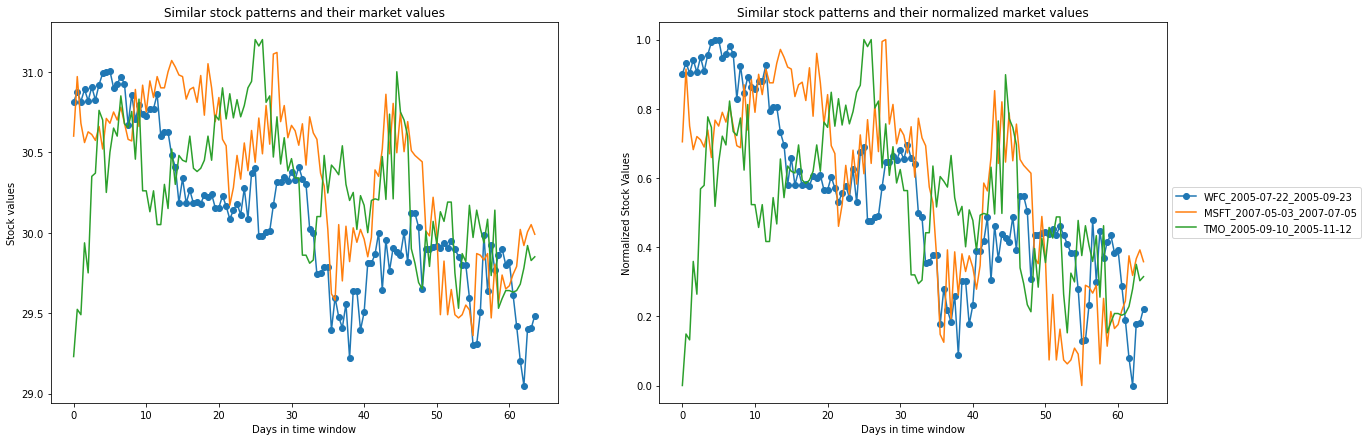

In [67]:
# which item you want to query
# Iterate and show query results for each query item

xb = np.array([apstock[1]]).astype(np.float32)

d, i = index.search(xb, k=20)

query_ids =[]
query_results = [[]]

for id in i[0]:
    idx = index_to_date[id]
    print(idx)
    dc = {'idx':idx,"values":date_to_value[idx],"score":0}
    query_results[0].append( dc)
    query_ids.append(idx)

for query_item, q_res in zip(query_ids, query_results):
    print(f'\nQueried: {query_item}')
    print(len(q_res[0]["values"]))
    
    
    res_df = pd.DataFrame(
        {
            'id': [res['idx'] for res in q_res], 
            'score': [res["score"] for res in q_res],
            'values': [res["values"] for res in q_res]
         }
    )
    res_df = filter_results(query_item, res_df, historical_only=False)
    show_query_results(query_item, res_df.head(6))

# Time Embeddings

